In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from preprocessing.getdata import *

In [2]:
df_a = get_csvdata_ADNI(False)
df_o= get_csvdata(drop_young=False, drop_contradictions=False)

df_a_train, df_a_test, y_a_train, y_a_test = train_test_split(df_a['ID'], df_a['label'], stratify=df_a['label'], random_state=42)

df_o_train, df_o_test, y_o_train, y_o_test = train_test_split(df_o['ID'], df_o['label'], stratify=df_o['label'], random_state=42)

y_test = np.concatenate((y_o_test, y_a_test))

In [3]:
N = 0
d = 2
mdict = {0: 90, 1: 110, 2: 90}

def get_test(dim, N, d):
    m = mdict[dim]
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI_new(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test

X_test0 = get_test(0, N, d)
X_test1 = get_test(1, N, d)
X_test2 = get_test(2, N, d)

In [4]:
model0 = tf.keras.models.load_model('../models/axis00')
model1 = tf.keras.models.load_model('../models/axis01')
model2 = tf.keras.models.load_model('../models/axis02')

In [5]:
y_prob0 = model0.predict(X_test0)
y_prob1 = model1.predict(X_test1)
y_prob2 = model2.predict(X_test2)

10/10 [==============================] - 14s 1s/step


In [6]:
y_prob0 = y_prob0.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob1 = y_prob1.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob2 = y_prob2.reshape(len(df_o_test)+len(df_a_test),1+2*N)

In [6]:
y_prob0 = np.mean(y_prob0, axis=1)
y_prob1 = np.mean(y_prob1, axis=1)
y_prob2 = np.mean(y_prob2, axis=1)

In [8]:
y_test = y_test.repeat(1+2*N)

In [9]:
y_test.shape

(951,)

In [7]:
print('accuracy of axis 0: ', accuracy_score(y_test, y_prob0.round()))
print('accuracy of axis 1: ', accuracy_score(y_test, y_prob1.round()))
print('accuracy of axis 2: ', accuracy_score(y_test, y_prob2.round()))

accuracy of axis 0:  0.7634069400630915
accuracy of axis 1:  0.7728706624605678
accuracy of axis 2:  0.7665615141955836


In [8]:
y_prob = np.stack((y_prob0, y_prob1, y_prob2)).T

In [14]:
#y_pred = np.mean(y_prob, axis=1).round()
y_pred = np.mean(y_prob.round(), axis=1).round()

accuracy:  0.773
recall:  0.94
precision:  0.73


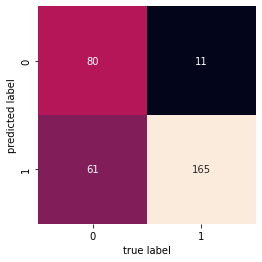

In [15]:
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(3))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [18]:
mask = (y_test == 1) & (y_pred == 0)

In [44]:
mask = (y_test == 0) & (y_pred == 1)

In [46]:
mask = (y_test == 0) & (y_pred == 0)

In [36]:
mask = (y_test == 0)

In [36]:
mask = ((y_test == 0) & (y_pred == 1) |  (y_test == 1) & (y_pred == 0))

In [40]:
dff = pd.concat([pd.merge(df_o_test, df_o), pd.merge(df_a_test, df_a)])

In [50]:
dff[mask]['Age']#.groupby('dataset').count()

45.5

In [32]:
N = 0
d = 5
mdict = {0: 95, 1: 110, 2: 90}

def get_test(dim, N, d, m):
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI_new(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test



In [33]:
results0 = []
results1 = []
results2 = []
for m in range(70,120,5):
    X_test0 = get_test(0, N, d, m)
    X_test1 = get_test(1, N, d, m)
    X_test2 = get_test(2, N, d, m)
    y_prob0 = model0.predict(X_test0)
    y_prob1 = model1.predict(X_test1)
    y_prob2 = model2.predict(X_test2)
    results0.append(accuracy_score(y_test, y_prob0.round()))
    results1.append(accuracy_score(y_test, y_prob1.round()))
    results2.append(accuracy_score(y_test, y_prob2.round()))
    print(results0, results1, results2)

10/10 [==============================] - 14s 1s/step
[0.7192429022082019] [0.7318611987381703] [0.7570977917981072]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694] [0.7318611987381703, 0.6845425867507886] [0.7570977917981072, 0.7697160883280757]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151] [0.7318611987381703, 0.6845425867507886, 0.7066246056782335] [0.7570977917981072, 0.7697160883280757, 0.7287066246056783]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151, 0.7255520504731862] [0.7318611987381703, 0.6845425867507886, 0.7066246056782335, 0.6813880126182965] [0.7570977917981072, 0.7697160883280757, 0.7287066246056783, 0.7570977917981072]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151, 0.7255520504731862, 0.7413249211356467] [0.7318611987381703, 0.684

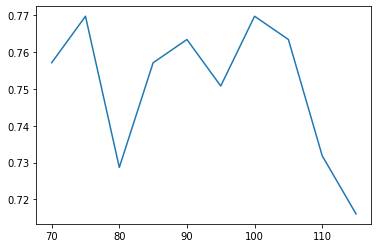

In [36]:
plt.plot(range(70,120,5), results2)

In [11]:
y_prob1.round(2)

array([0.22, 0.58, 0.12, 0.15, 0.22, 0.11, 0.59, 0.15, 0.14, 0.2 , 0.26,
       0.56, 0.41, 0.63, 0.09, 0.83, 0.12, 0.31, 0.12, 0.41, 0.12, 0.6 ,
       0.16, 0.28, 0.14, 0.08, 0.24, 0.18, 0.12, 0.12, 0.16, 0.13, 0.51,
       0.17, 0.13, 0.12, 0.57, 0.49, 0.16, 0.09, 0.22, 0.41, 0.14, 0.16,
       0.43, 0.46, 0.58, 0.17, 0.08, 0.12, 0.44, 0.75, 0.17, 0.48, 0.51,
       0.24, 0.73, 0.17, 0.19, 0.12, 0.13, 0.85, 0.34, 0.31, 0.13, 0.08,
       0.14, 0.72, 0.73, 0.35, 0.25, 0.32, 0.11, 0.1 , 0.13, 0.15, 0.51,
       0.33, 0.1 , 0.82, 0.65, 0.51, 0.57, 0.08, 0.12, 0.36, 0.19, 0.5 ,
       0.18, 0.28, 0.12, 0.12, 0.47, 0.38, 0.2 , 0.25, 0.13, 0.09, 0.53,
       0.11, 0.18, 0.64, 0.59, 0.45, 0.47, 0.45, 0.09, 0.12, 0.09, 0.68,
       0.65, 0.8 , 0.55, 0.73, 0.72, 0.78, 0.72, 0.81, 0.57, 0.65, 0.59,
       0.63, 0.61, 0.84, 0.8 , 0.78, 0.86, 0.86, 0.69, 0.72, 0.61, 0.62,
       0.77, 0.55, 0.81, 0.73, 0.71, 0.85, 0.82, 0.53, 0.52, 0.62, 0.78,
       0.81, 0.71, 0.77, 0.79, 0.8 , 0.74, 0.86, 0.

In [ ]:
dim = 0
85: 0.751
90: 0.767
95: 0.757
100: 0.754
105: 0.751

In [17]:
y_prob0.shape


(317,)

In [29]:
df = pd.concat([df_o, df_a])

In [33]:
df.groupby('Group').count()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,...,dataset,Image Data ID,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
Group,,,,,,,,,,,,,,,,,,,,,
AD,198,0,198,0,0,0,0,0,0,0,...,198,198,198,198,198,198,198,198,198,198
CN,228,0,228,0,0,0,0,0,0,0,...,228,228,228,228,228,228,228,228,228,228
MCI,405,0,405,0,0,0,0,0,0,0,...,405,405,405,405,405,405,405,405,405,405


In [35]:
df.groupby('CDR_').count()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,...,Image Data ID,Group,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
CDR_,,,,,,,,,,,,,,,,,,,,,
0.0,336,336,336,135,133,135,336,336,336,336,...,0,0,0,0,0,0,0,0,0,0
0.5,70,70,70,70,57,70,70,70,70,70,...,0,0,0,0,0,0,0,0,0,0
1.0,28,28,28,28,24,28,28,28,28,28,...,0,0,0,0,0,0,0,0,0,0
2.0,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
